### Imports

In [5]:
import tensorflow as tf

# Get rid of tensorflow GPU console log spam
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense, Dropout, Flatten, AveragePooling2D
from pathlib import Path

import matplotlib.pylab as plt
import numpy as np
import os

In [6]:
#Limit GPU memory usage

tf.config.set_logical_device_configuration(
        tf.config.list_physical_devices('GPU')[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3000)])

### Import Data

In [7]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

gen_params = {"samplewise_center":True,\
              "samplewise_std_normalization":True}

train_generator = ImageDataGenerator(**gen_params, validation_split=0.2)

In [8]:
train_data_dir = '../dataset'
class_names = os.listdir('../dataset')
model_name = 'VGG16_TL1_FT3.h5'

In [9]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode='categorical',
                                               classes=class_names,
                                               subset='training',
                                               interpolation="nearest",
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode='categorical',
                                               classes=class_names,
                                               subset='validation',
                                               interpolation="nearest",
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

Found 24952 images belonging to 52 classes.
Found 6206 images belonging to 52 classes.


### Sample Data Visualization

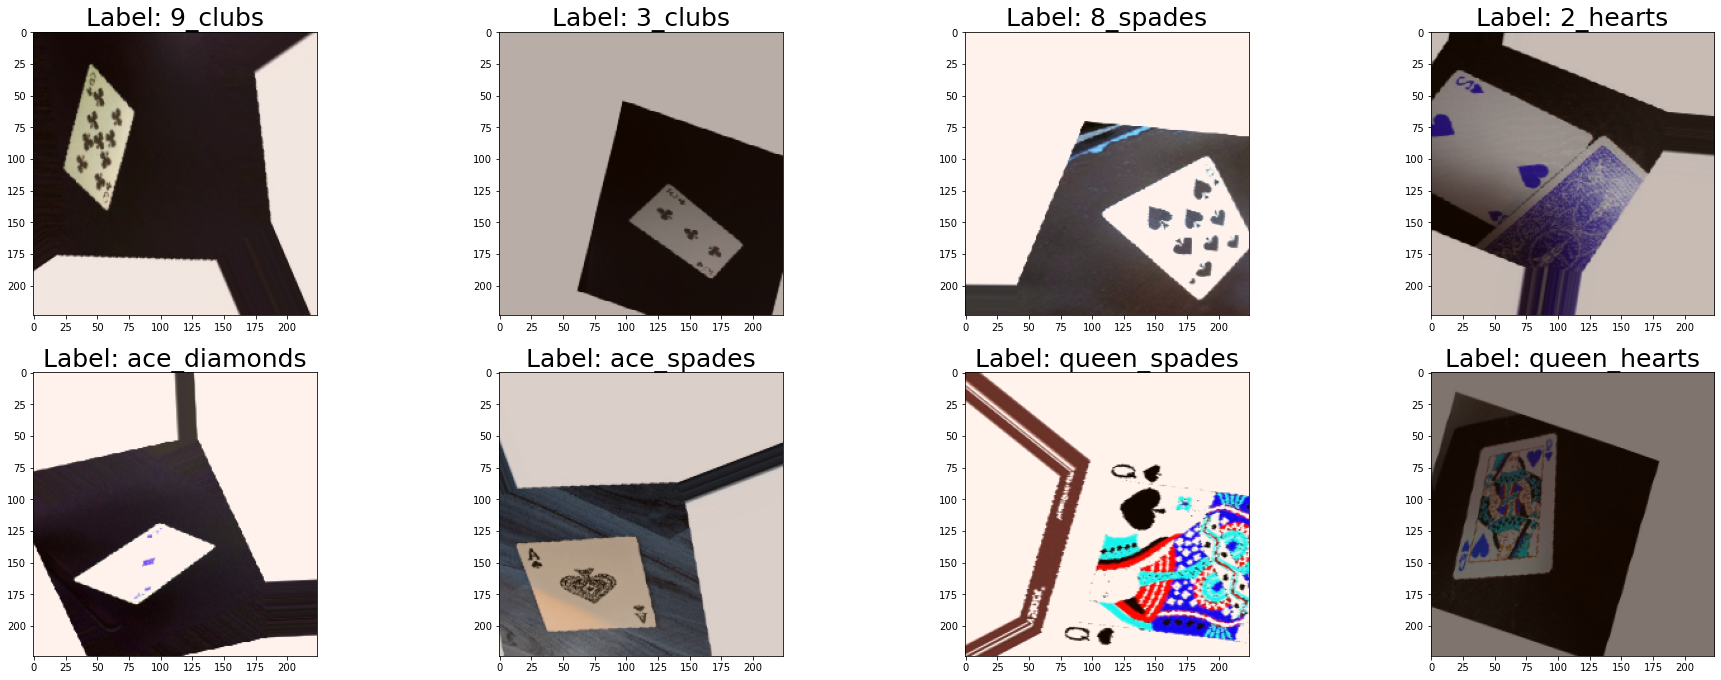

In [10]:
plt.figure(figsize = (32,24))
Xbatch,Ybatch = traingen.__getitem__(0)

for ii in range(int(BATCH_SIZE)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    class_idx = int(Ybatch[ii].argmax())
    plt.title("Label: {}".format(class_names[class_idx]), fontsize=25)
plt.show()

### Create Transfer Learning Model

In [11]:
# Function code taken and adapted from https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape,
                     classes=n_classes)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(208, activation='relu')(top_model)
    top_model = Dense(104, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [14]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
learn_rate = Adam(learning_rate=1e-3)
n_classes=len(class_names)

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

VGG16_model = create_model(input_shape, n_classes, learn_rate, fine_tune=3)

In [15]:
print("Initial VGG16 Training Model")
print(VGG16_model.summary())

Initial VGG16 Training Model
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (

In [29]:
# ModelCheckpoint callback - save best weights
model_checkpoint = ModelCheckpoint(filepath=model_name,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   verbose=1,
                                   monitor='val_loss')

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10)

### Fit Model to Data

In [30]:
VGG16_history = VGG16_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[model_checkpoint, early_stop],
                            verbose=1)

Epoch 1/50
3119/3119 [==============================] - ETA: 0s - loss: 3.9658 - accuracy: 0.0185
Epoch 1: val_loss improved from inf to 3.95032, saving model to VGG16_TL1_FT3.h5
3119/3119 [==============================] - 323s 103ms/step - loss: 3.9658 - accuracy: 0.0185 - val_loss: 3.9503 - val_accuracy: 0.0210
Epoch 2/50
3119/3119 [==============================] - ETA: 0s - loss: 3.9513 - accuracy: 0.0187
Epoch 2: val_loss improved from 3.95032 to 3.95022, saving model to VGG16_TL1_FT3.h5
3119/3119 [==============================] - 321s 103ms/step - loss: 3.9513 - accuracy: 0.0187 - val_loss: 3.9502 - val_accuracy: 0.0211
Epoch 3/50
3119/3119 [==============================] - ETA: 0s - loss: 3.9512 - accuracy: 0.0206
Epoch 3: val_loss improved from 3.95022 to 3.95017, saving model to VGG16_TL1_FT3.h5
3119/3119 [==============================] - 326s 104ms/step - loss: 3.9512 - accuracy: 0.0206 - val_loss: 3.9502 - val_accuracy: 0.0215
Epoch 4/50
3119/3119 [======================

KeyboardInterrupt: 

### Load Model from Saved .hf File for Further Fitting (not needed for VGG16)

In [14]:
VGG16_model = tf.keras.models.load_model('VGG16_TL1_FT2.h5')

In [ ]:
VGG16_history = VGG16_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[model_checkpoint, early_stop],
                            verbose=1)